# Data Visualization

In [1]:
import cv2
import matplotlib.pyplot as plt

%matplotlib inline

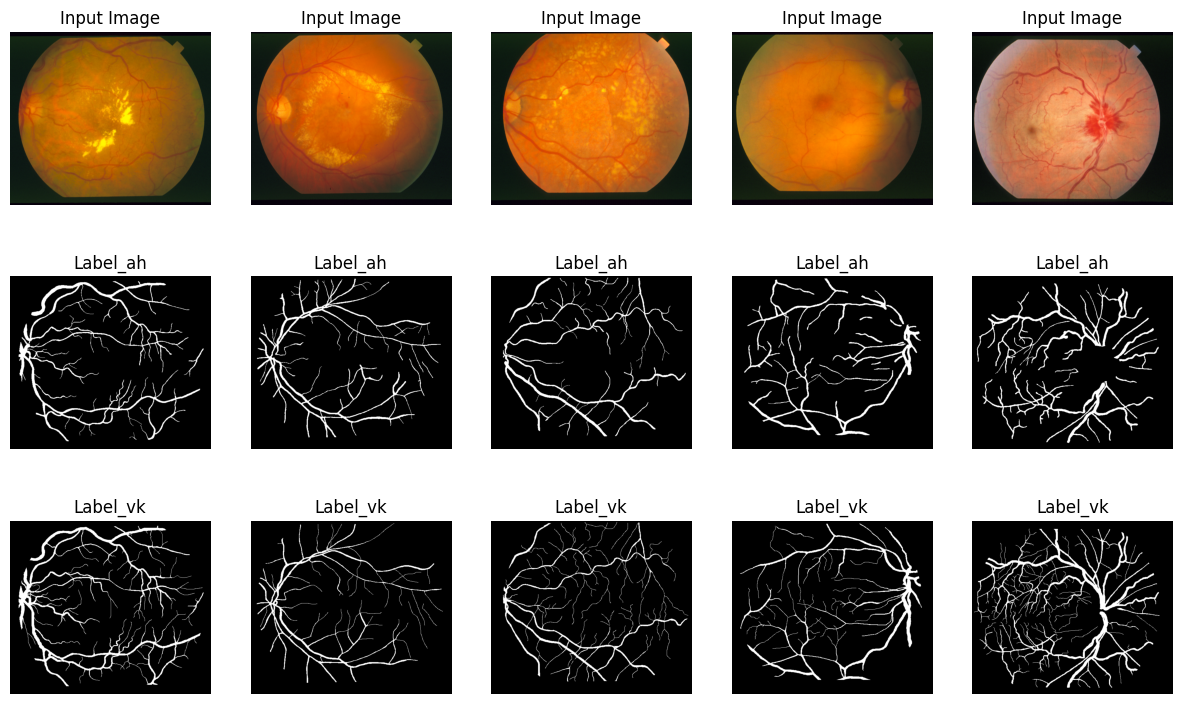

In [20]:
img = [cv2.imread(f"/kaggle/input/stare-segmentation/stare-images/im000{i+1}.ppm") for i in range(5)]
img_label_vk = [cv2.imread(f"/kaggle/input/stare-segmentation/labels-vk/im000{i+1}_vk.ppm",0) for i in range(5)]
img_label_ah = [cv2.imread(f"/kaggle/input/stare-segmentation/labels-ah/im000{i+1}_ah.ppm",0) for i in range(5)]

fig = plt.figure(figsize = (15,9))
for i in range(5):
    plt.subplot(3,5,i+1)
    plt.imshow(cv2.cvtColor(img[i], cv2.COLOR_RGB2BGR))
    plt.title('Input Image')
    plt.axis('off')
    plt.subplot(3,5,i+6)
    plt.imshow(img_label_ah[i], cmap='gray')
    plt.title('Label_ah')
    plt.axis('off')
    plt.subplot(3,5,i+11)
    plt.imshow(img_label_vk[i], cmap='gray')
    plt.title('Label_vk')
    plt.axis('off')
    
plt.show()


# Model Architectures

## Encoder and Decoder Blocks

In [24]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [25]:
class EncoderBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride=2, padding=1):
        super(EncoderBlock, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride=stride, padding=padding)
        self.batch_norm = nn.BatchNorm2d(out_channels)
        self.leaky_relu = nn.LeakyReLU()

    def forward(self, x):
        x = self.conv(x)
        x = self.batch_norm(x)
        x = self.leaky_relu(x)
        return x

class DecoderBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride=2, padding=1, output_padding=1):
        super(DecoderBlock, self).__init__()
        self.deconv = nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride=stride, padding=padding, output_padding=output_padding)
        self.batch_norm = nn.BatchNorm2d(out_channels)
        self.leaky_relu = nn.LeakyReLU()

    def forward(self, x):
        x = self.deconv(x)
        x = self.batch_norm(x)
        x = self.leaky_relu(x)
        return x

## Basic autoencoder from scratch

In [26]:
class Autoencoder(nn.Module):
    def __init__(self, input_channels):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            EncoderBlock(in_channels=input_channels, out_channels=32, kernel_size=5, padding=2),
            EncoderBlock(in_channels=32, out_channels=32, kernel_size=3),
            EncoderBlock(in_channels=32, out_channels=64, kernel_size=3),
            EncoderBlock(in_channels=64, out_channels=64, kernel_size=3),
        )
        self.feature_layer = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.decoder = nn.Sequential(
            DecoderBlock(in_channels=128, out_channels=64, kernel_size=3),
            DecoderBlock(in_channels=64, out_channels=64, kernel_size=3),
            DecoderBlock(in_channels=64, out_channels=32, kernel_size=3),
            DecoderBlock(in_channels=32, out_channels=32, kernel_size=5, padding=2),
        )
        self.output_layer = nn.ConvTranspose2d(in_channels=32, out_channels=1, kernel_size=3, padding=1)
    
    def forward(self, x):
        x = self.encoder(x)
        x = self.feature_layer(x)
        x = self.decoder(x)
        x = torch.sigmoid(self.output_layer(x))
        return x

In [27]:
# Example usage
input_shape = (3, 512, 512)  # Assuming input images are 512x512 rgb img
batch_size = 32
x = torch.randn(batch_size, *input_shape)

model = Autoencoder(input_channels=input_shape[0])
output = model(x)
print(output.shape)  # Should print torch.Size([32, 1, 512, 512])

torch.Size([32, 1, 512, 512])


# Dataset Creation

In [7]:
import os
from PIL import Image
import torch
import random
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

In [8]:
class CustomPPMDataset(Dataset):
    def __init__(self, image_dir, label_dir, transform=None):
        self.image_dir = image_dir
        self.label_dir = label_dir
        self.transform = transform
        self.image_files = sorted([f for f in os.listdir(image_dir) if f.endswith('.ppm')])
        self.label_files = sorted([f for f in os.listdir(label_dir) if f.endswith('.ppm')])

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_name = self.image_files[idx]
        label_name = self.label_files[idx]
        
        img_path = os.path.join(self.image_dir, img_name)
        label_path = os.path.join(self.label_dir, label_name)
        
        image = Image.open(img_path).convert('RGB')
        label = Image.open(label_path).convert('L')
        
        if self.transform:
            seed = random.randint(0,50000)
            random.seed(seed)
            torch.manual_seed(seed)
            image = self.transform(image)
            random.seed(seed)
            torch.manual_seed(seed)
            label = self.transform(label)
        
        return image, label

# Define the transformation
transform = transforms.Compose([
    transforms.Resize((512, 512)),
    transforms.ToTensor(),
    transforms.RandomResizedCrop(size=(512, 512), antialias=True),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.RandomAffine(180),
])

# Initialize dataset
dataset = CustomPPMDataset(image_dir='/kaggle/input/stare-segmentation/stare-images', label_dir='/kaggle/input/stare-segmentation/labels-vk', transform=transform)

# Training and testing functions

## Hyperparameters

In [9]:
BATCH_SIZE = 32
INPUT_SHAPE = (3,512,512)

## Training

In [10]:
import os
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader, Subset
from torchvision import transforms
from sklearn.model_selection import KFold
import numpy as np

In [ ]:
def train_model(train_loader, model, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    
    return running_loss / len(train_loader)

def validate_model(val_loader, model, criterion, device):
    model.eval()
    running_loss = 0.0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
    
    return running_loss / len(val_loader)

# Set up k-fold cross-validation
k_folds = 5
kfold = KFold(n_splits=k_folds, shuffle=True)

# For fold results
results = {}

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize the model for this fold
model = Autoencoder(input_channels=INPUT_SHAPE[0]).to(device)

# Initialize optimizer and criterion
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()

# Start k-fold cross-validation
for fold, (train_ids, val_ids) in enumerate(kfold.split(dataset)):
    print(f'FOLD {fold+1}')
    print('--------------------------------')

    # Sample elements randomly from a given list of ids, no replacement
    train_subsampler = Subset(dataset, train_ids)
    val_subsampler = Subset(dataset, val_ids)

    # Define data loaders for training and validation
    train_loader = DataLoader(train_subsampler, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
    val_loader = DataLoader(val_subsampler, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

    # Run the training loop for defined epochs
    for epoch in range(100):
        train_loss = train_model(train_loader, model, criterion, optimizer, device)
        val_loss = validate_model(val_loader, model, criterion, device)
        print(f'Epoch {epoch+1}: Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}')

    # Save the model
    torch.save(model.state_dict(), f'model_fold_{fold+1}.pth')

    # Evaluation for this fold
    results[fold] = val_loss

# Print fold results
print('K-FOLD CROSS VALIDATION RESULTS FOR 5 FOLDS')
print('--------------------------------')
for key, value in results.items():
    print(f'Fold {key+1}: {value:.4f}')

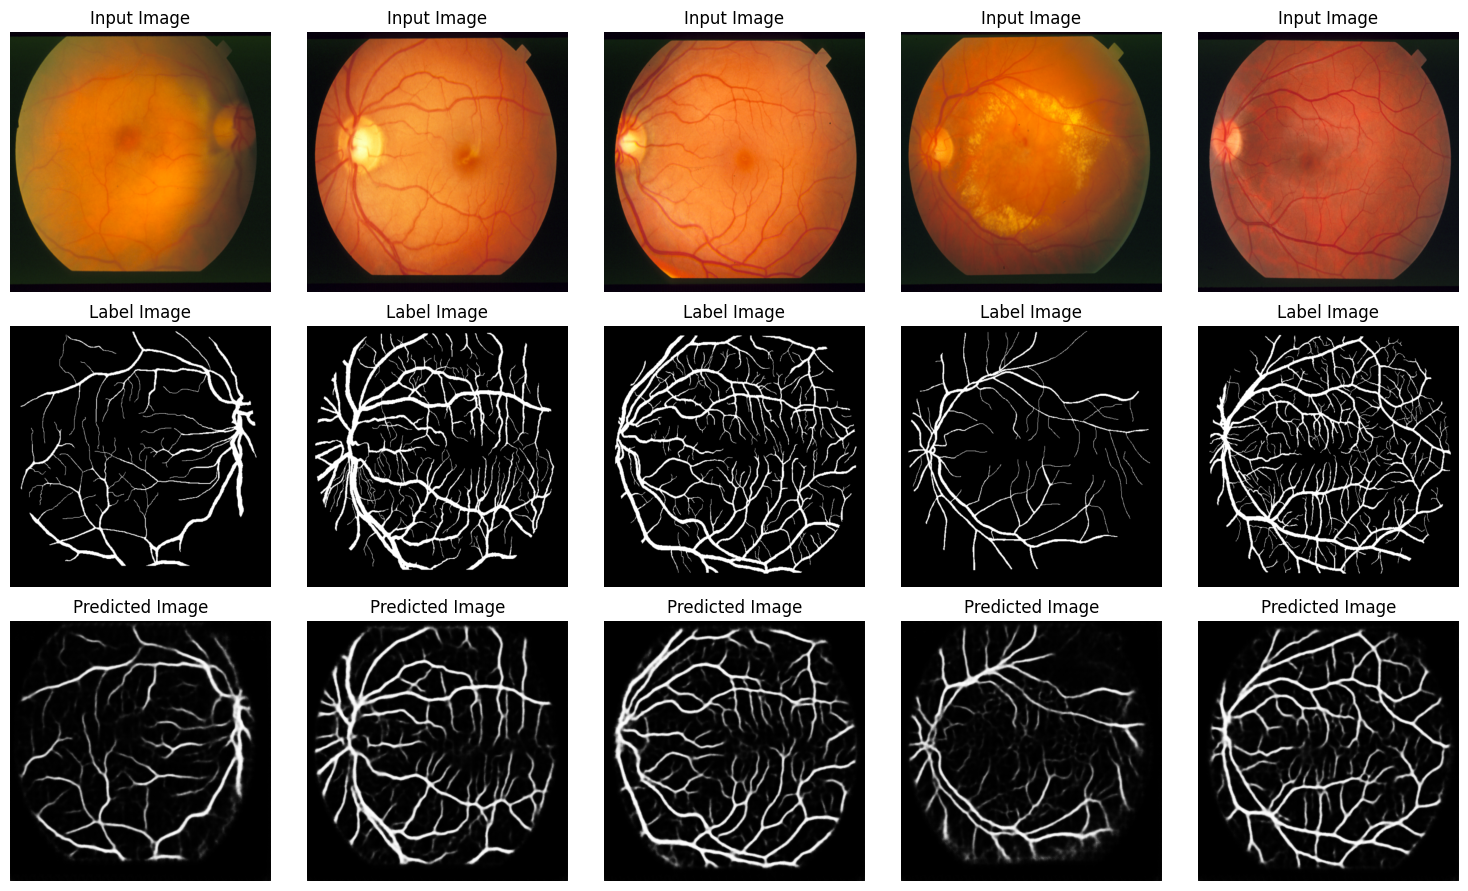

In [12]:
transform = transforms.Compose([
    transforms.Resize((512, 512)),
    transforms.ToTensor(),
])

dataset = CustomPPMDataset(image_dir='/kaggle/input/stare-segmentation/stare-images', label_dir='/kaggle/input/stare-segmentation/labels-vk', transform=transform)

dataloader = DataLoader(dataset, batch_size=5, shuffle=True, num_workers=4)

# Define the model (assuming Autoencoder class is defined and imported)
model = Autoencoder(input_channels=3)
model.load_state_dict(torch.load('/kaggle/working/model_fold_5.pth'))  # Load your trained model
model.eval()

# Fetch 5 samples from the dataloader
images, labels = next(iter(dataloader))

# Move to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
images = images.to(device)
labels = labels.to(device)

# Predict the labels for the samples
with torch.no_grad():
    outputs = model(images)

# Move tensors to CPU for visualization
images = images.cpu()
labels = labels.cpu()
outputs = outputs.cpu()

# Function to display images
def imshow(img, title=None):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)), interpolation='nearest')
    if title is not None:
        plt.title(title)
    plt.axis('off')

# Create a 3x5 grid of subplots
fig, axs = plt.subplots(3, 5, figsize=(15, 9))

# Display input, label, and predicted images
for i in range(5):
    axs[0, i].imshow(np.transpose(images[i], (1, 2, 0)))
    axs[0, i].set_title('Input Image')
    axs[0, i].axis('off')
    
    axs[1, i].imshow(labels[i].squeeze(), cmap='gray')
    axs[1, i].set_title('Label Image')
    axs[1, i].axis('off')
    
    axs[2, i].imshow(outputs[i].squeeze(), cmap='gray')
    axs[2, i].set_title('Predicted Image')
    axs[2, i].axis('off')

plt.tight_layout()
plt.show()

## Using model to predict mask in unlabeled images

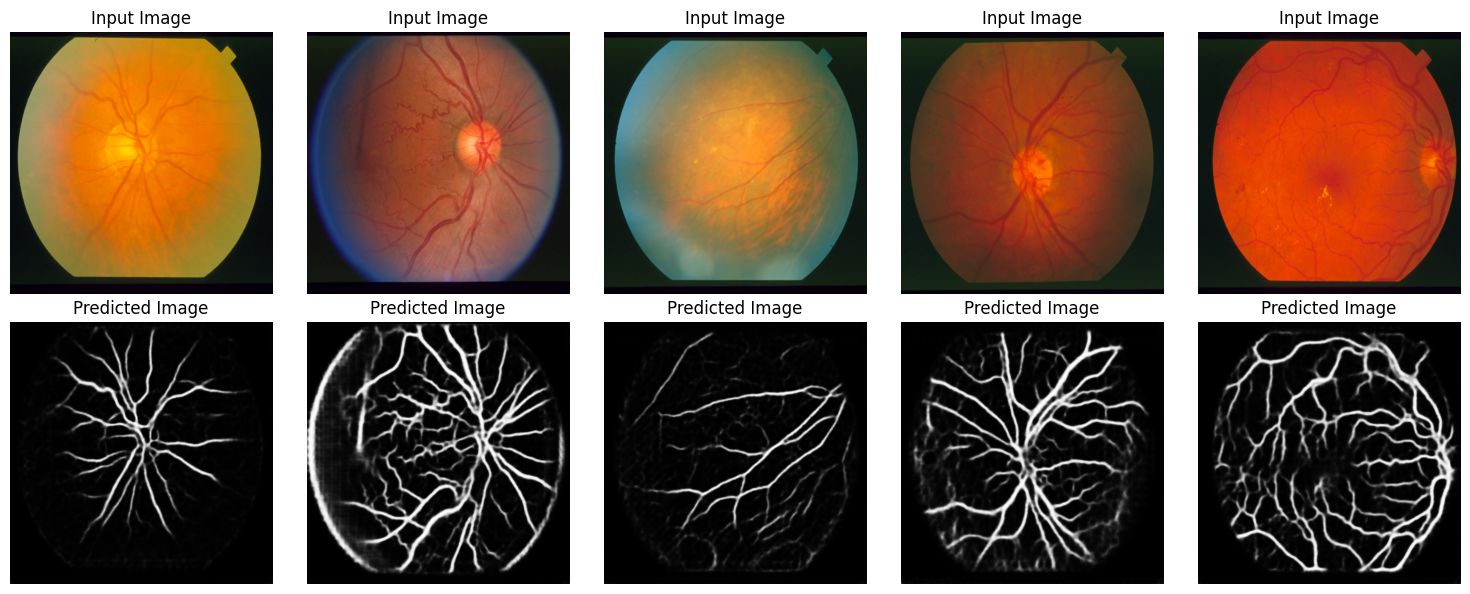

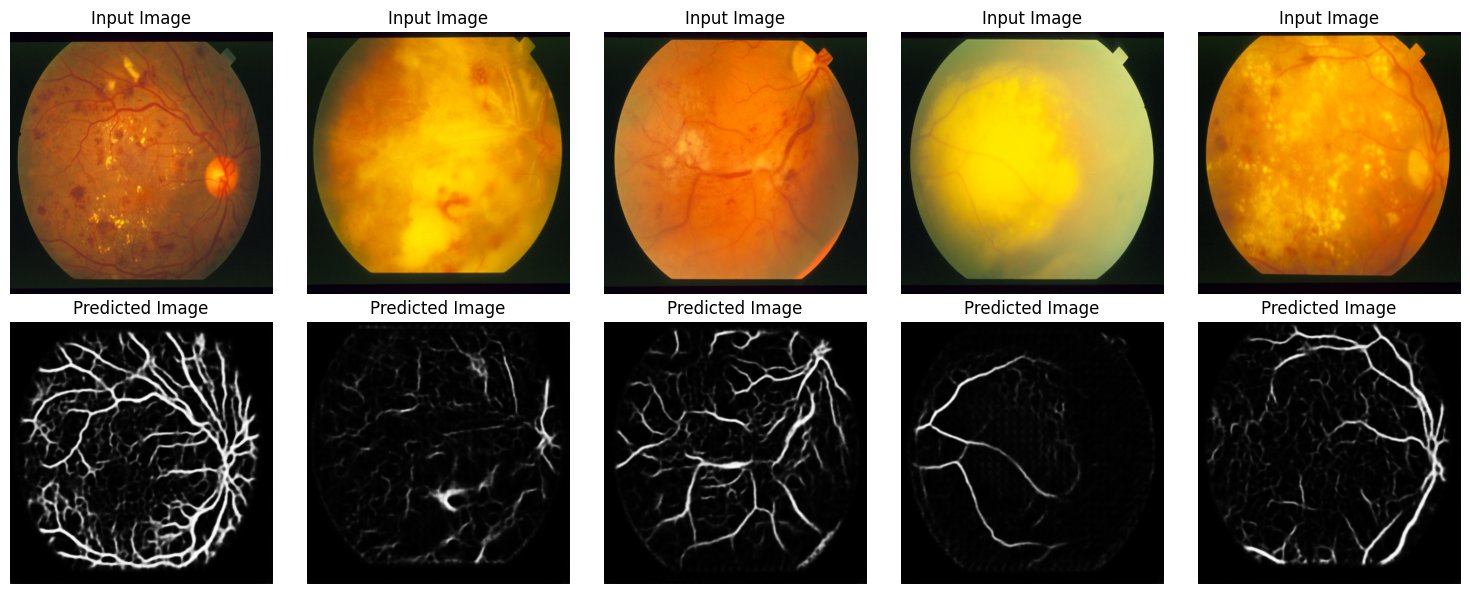

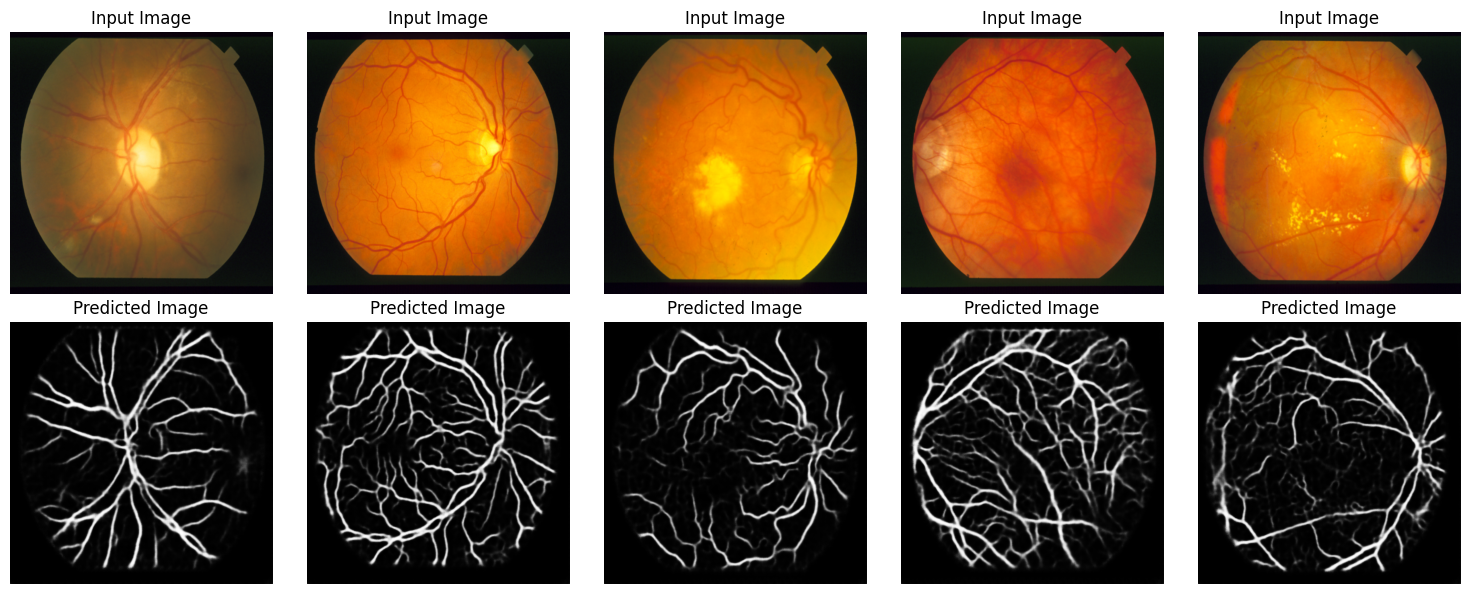

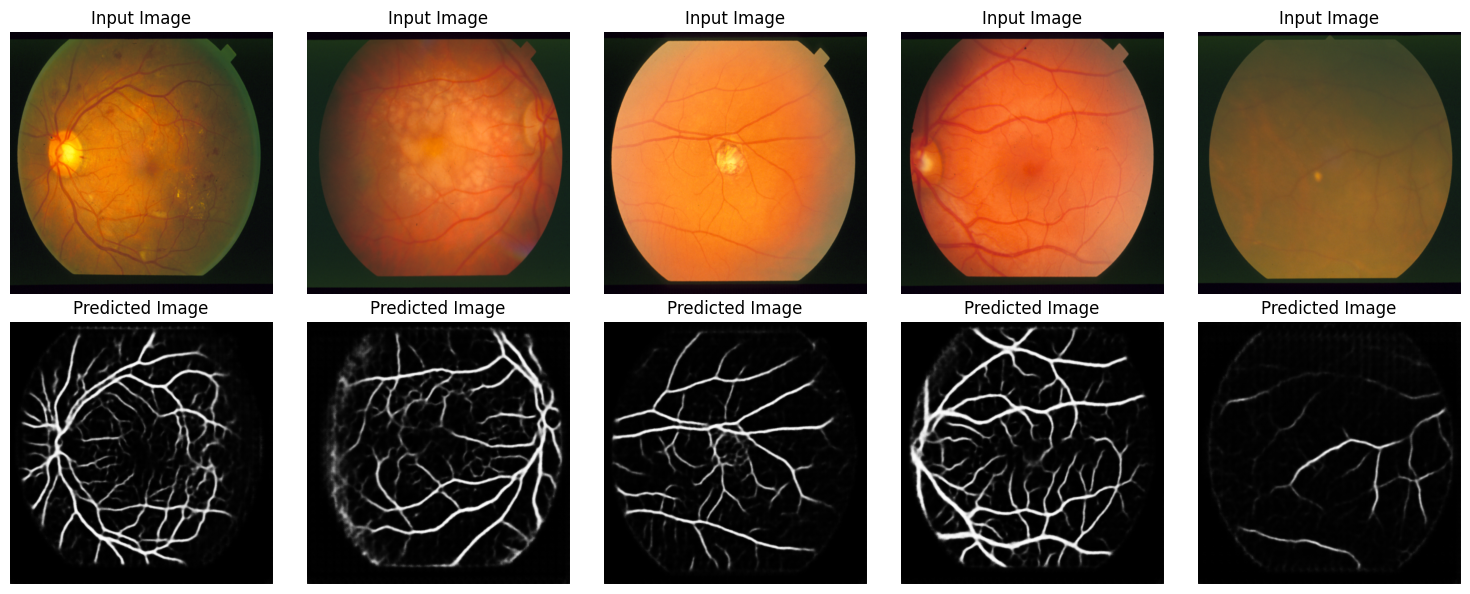

In [28]:
transform = transforms.Compose([
    transforms.Resize((512, 512)),
    transforms.ToTensor(),
])

dataset = CustomPPMDataset(image_dir='/kaggle/input/stare-dataset', label_dir='/kaggle/input/stare-dataset', transform=transform)

dataloader = DataLoader(dataset, batch_size=5, shuffle=True, num_workers=4)

# Define the model (assuming Autoencoder class is defined and imported)
model = Autoencoder(input_channels=3)
model.load_state_dict(torch.load('/kaggle/working/model_fold_5.pth'))  # Load your trained model
model.eval()


for x in range(4):
    # Fetch 5 samples from the dataloader
    images, labels = next(iter(dataloader))

    # Move to GPU if available
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    images = images.to(device)
#     labels = labels.to(device)

    # Predict the labels for the samples
    with torch.no_grad():
        outputs = model(images)

    # Move tensors to CPU for visualization
    images = images.cpu()
#     labels = labels.cpu()
    outputs = outputs.cpu()

    # Function to display images
    def imshow(img, title=None):
        npimg = img.numpy()
        plt.imshow(np.transpose(npimg, (1, 2, 0)), interpolation='nearest')
        if title is not None:
            plt.title(title)
        plt.axis('off')

    # Create a 2x5 grid of subplots
    fig, axs = plt.subplots(2, 5, figsize=(15, 6))

    # Display input, label, and predicted images
    for i in range(5):
        axs[0, i].imshow(np.transpose(images[i], (1, 2, 0)))
        axs[0, i].set_title('Input Image')
        axs[0, i].axis('off')

#         axs[1, i].imshow(labels[i].squeeze(), cmap='gray')
#         axs[1, i].set_title('Label Image')
#         axs[1, i].axis('off')

        axs[1, i].imshow(outputs[i].squeeze(), cmap='gray')
        axs[1, i].set_title('Predicted Image')
        axs[1, i].axis('off')

    plt.tight_layout()
    plt.show()